<h2> We use a Neural Network embedding layer trained to feed the input of the Forest Decision<h2>

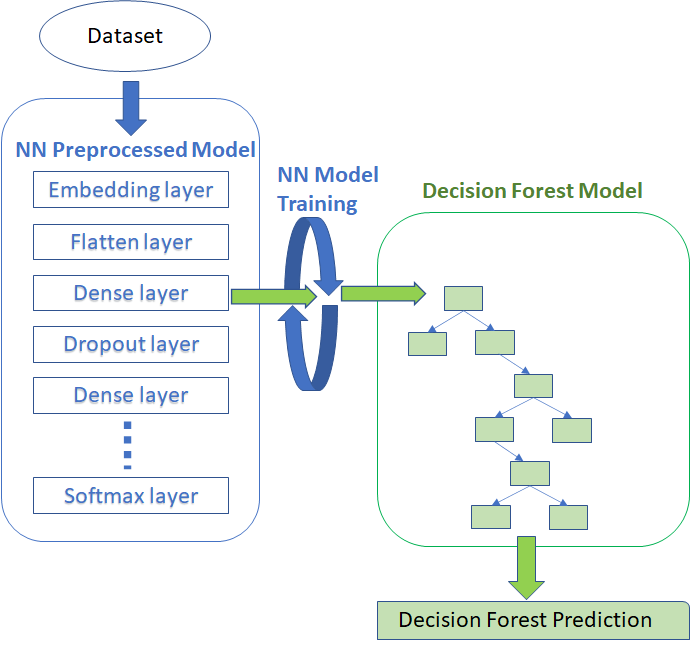

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import initializers

from keras.models import Model

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-jun-2021/test.csv')

In [ ]:
target = pd.get_dummies(train['target'])

<h3> Decision Forest building ("concatenation" of decision trees)

In [ ]:
"""
Adapted from : 
https://keras.io/examples/structured_data/deep_neural_decision_forests/
"""
class Decision_Tree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super(Decision_Tree, self).__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes
        num_used_features = int(num_features * used_features_rate)    
        one_hot = np.eye(num_features)                                
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )                                                            
        self.used_features_mask = one_hot[sampled_feature_indicies]   
        self.pi = tf.Variable(
            initial_value = tf.random_normal_initializer()(
            shape = [self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )
        
        self.decision_fn = layers.Dense(
            units=self.num_leaves, 
            activation="sigmoid", 
            name="decision"
            )

    def call(self, features):
        batch_size = tf.shape(features)[0]
        features = tf.matmul(
            features, 
            self.used_features_mask, 
            transpose_b=True
            )  
        decisions = tf.expand_dims(
            self.decision_fn(features),
            axis=2
            )  
        decisions = layers.concatenate(
            [decisions, 1 - decisions],
            axis=2
            ) 

        mu = tf.ones([batch_size, 1, 1]) 
        begin_idx = 1
        end_idx = 2

        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  
            mu = tf.tile(mu, (1, 1, 2))  
            level_decisions = decisions[:, begin_idx:end_idx, :]  
            mu = mu * level_decisions  
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  
        probabilities = keras.activations.softmax(self.pi)  
        outputs = tf.matmul(mu, probabilities) 
        
        return outputs

In [ ]:
class Decision_Forest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super(Decision_Forest, self).__init__()
        self.ensemble = []
        self.num_classes = num_classes
        
        for _ in range(num_trees):
            self.ensemble.append(
                Decision_Tree(depth, 
                              num_features,
                              used_features_rate,
                              self.num_classes)
                                )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, 
                            num_classes])
        
        for tree in self.ensemble:
            outputs += tree(inputs)
            
        outputs /= len(self.ensemble)
        
        return outputs

num_trees = 20
depth = 5
used_features_rate = 0.5
num_classes = 9
num_features = 20
forest_model = Decision_Forest(
                        num_trees,
                        depth, 
                        num_features,
                        used_features_rate,
                        num_classes
                        )

In [ ]:
metrics = [tf.keras.metrics.CategoricalCrossentropy()]
loss = tf.keras.losses.CategoricalCrossentropy()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0000001, patience=2, verbose=0,
    mode='min', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=0,
    mode='min', min_delta=0.0000001, cooldown=0, min_lr=10e-7)

<h3> Definition model and training + prediction

In [ ]:
N_FOLDS = 10
SEED = 2021
oof_embedding = np.zeros((train.shape[0],9))
pred_embedding = np.zeros((test.shape[0],9))
oof_forest = np.zeros((train.shape[0],9))
pred_forest = np.zeros((test.shape[0],9))

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, ts_idx) in enumerate(skf.split(train,train.iloc[:,-1])):
    print(f"\n===== TRAINING FOLD {fold} =====\n")
       
    X_train = train.iloc[:,1:-1].iloc[tr_idx]
    y_train = target.iloc[tr_idx]
    X_test = train.iloc[:,1:-1].iloc[ts_idx]
    y_test = target.iloc[ts_idx]
    

    #----------NN Model definition ----------
    
    inp = layers.Input(shape = (75,))
    x = layers.Embedding(400, 8, input_length = 256)(inp)
    x = layers.Flatten()(x)
    # API is the future imput layer for decision forest :
    API = layers.Dense(20, 
                       activation='relu',
                       kernel_initializer='random_uniform',
                       bias_initializer=initializers.Constant(0.1))(x)
    x = layers.Dropout(0.3)(API)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(20, activation = 'relu')(x)
    output = layers.Dense(9, activation = 'softmax')(x)

    #----------Models instantiation ---------

    model_embedding = Model(inp,output)
    model_embedding_without_head = tf.keras.models.Model(inputs=model_embedding.inputs,outputs=API)
    model_forest = Model(inp,forest_model(API))

    #----------NN Model training ------------

    model_embedding.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss = loss ,
            metrics = metrics)

    model_embedding.fit(X_train,y_train,
            validation_data=(X_test,y_test),
            epochs=50,
            verbose=0,
            batch_size = 256,
            callbacks=[es,plateau])
     
    #----------NN Model prediction------------
    
    oof_embedding[ts_idx] = model_embedding.predict(X_test)
    score_embedding = log_loss(y_test, oof_embedding[ts_idx])
    print(f"\nFOLD {fold} Score for NN model {score_embedding}\n")
    pred_embedding += model_embedding.predict(test.iloc[:,1:]) / N_FOLDS
    
    
    #----------Model forest training -----------
    
    model_forest.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = loss,
            metrics = metrics)
    
    model_forest.fit(X_train,y_train,
                    validation_data = (X_test,y_test),
                    batch_size = 256,
                    epochs = 50,
                    verbose = 0,
                    callbacks = [es,plateau])
    
    #----------Model forest prediction------------ 
        
    oof_forest[ts_idx] = model_forest.predict(X_test)
    score_forest = log_loss(y_test, oof_forest[ts_idx])
    print(f"\nFOLD {fold} Score for decision forest : {score_forest}\n")
    
    pred_forest += model_forest.predict(test.iloc[:,1:]) / N_FOLDS
    
score_embedding = log_loss(target, oof_embedding)
print(f"\n=== FINAL SCORE FOR NN MODEL : {score_embedding}===\n")   

score_forest = log_loss(target, oof_forest)
print(f"\n=== FINAL SCORE FOR DECISION FOREST : {score_forest}===\n")  


In [ ]:
submission1 = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
submission1['Class_1']=pred_forest[:,0]
submission1['Class_2']=pred_forest[:,1]
submission1['Class_3']=pred_forest[:,2]
submission1['Class_4']=pred_forest[:,3]
submission1['Class_5']=pred_forest[:,4]
submission1['Class_6']=pred_forest[:,5]
submission1['Class_7']=pred_forest[:,6]
submission1['Class_8']=pred_forest[:,7]
submission1['Class_9']=pred_forest[:,8]


In [ ]:
submission1.to_csv("Keras_forest.csv", index=False)

In [ ]:
submission2 = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
submission2['Class_1']=pred_embedding[:,0]
submission2['Class_2']=pred_embedding[:,1]
submission2['Class_3']=pred_embedding[:,2]
submission2['Class_4']=pred_embedding[:,3]
submission2['Class_5']=pred_embedding[:,4]
submission2['Class_6']=pred_embedding[:,5]
submission2['Class_7']=pred_embedding[:,6]
submission2['Class_8']=pred_embedding[:,7]
submission2['Class_9']=pred_embedding[:,8]

In [ ]:
submission2.to_csv("Keras_embedding.csv", index=False)